# Data import

In [1]:
import pandas as pd

url = 'https://raw.githubusercontent.com/dbonacorsi/AML_Adv_AA1920/master/datasets/monthly-car-sales.csv'

names = ['Month', 'Sales']
series = pd.read_csv(url, names=names, header=0, index_col=0)
data = series.values

series

,Sales
Month,
1960-01,6550
1960-02,8728
1960-03,12026
1960-04,14395
1960-05,14587
...,...
1968-08,16722
1968-09,14385
1968-10,21342


In [2]:
print(series.shape)

(108, 1)


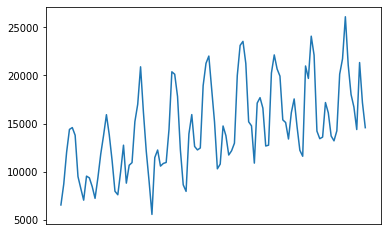

In [3]:
from matplotlib import pyplot

pyplot.plot(series)
pyplot.xticks([])
pyplot.show()

# CNN-LSTM

In [4]:
# evaluate cnn-lstm for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

Using TensorFlow backend.


In [5]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
  return data[:-n_test], data[-n_test:]

In [6]:
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
  df = DataFrame(data)
  cols = list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
  # put it all together
  agg = concat(cols, axis=1)
  # drop rows with NaN values
  agg.dropna(inplace=True)
  return agg.values

In [7]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
  return sqrt(mean_squared_error(actual, predicted))

In [8]:
# fit a model
def model_fit(train, config):
  # unpack config
  n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config      #<---- CNN-LSTM
  n_input = n_seq * n_steps                                                     #<---- CNN-LSTM
  # prepare data
  data = series_to_supervised(train, n_input)                                   #<---- CNN-LSTM
  train_x, train_y = data[:, :-1], data[:, -1]                                  #<---- CNN-LSTM
  train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))              #<---- CNN-LSTM
  
  # define CNN input model
  model = Sequential()                                                          #<---- CNN-LSTM
  model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu',
  input_shape=(None,n_steps,1))))
  model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu')))
  model.add(TimeDistributed(MaxPooling1D()))
  model.add(TimeDistributed(Flatten()))
  
  # define LSTM and output model
  model.add(LSTM(n_nodes, activation='relu'))
  model.add(Dense(n_nodes, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')
  # fit
  model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
  return model


In [9]:
# forecast with a pre-fit model
def model_predict(model, history, config):
  # unpack config
  n_seq, n_steps, _, _, _, _, _ = config                                        #<---- CNN-LSTM
  n_input = n_seq * n_steps                                                     #<---- CNN-LSTM
  # prepare data
  x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))           #<---- CNN-LSTM
  # forecast
  yhat = model.predict(x_input, verbose=0)
  return yhat[0]

In [10]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
  predictions = list()
  # split dataset
  train, test = train_test_split(data, n_test)
  # fit model
  model = model_fit(train, cfg)
  # seed history with training dataset
  history = [x for x in train]
  # step over each time-step in the test set
  for i in range(len(test)):
    # fit model and make forecast for history
    yhat = model_predict(model, history, cfg)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])
  # estimate prediction error
  error = measure_rmse(test, predictions)
  print(' > %.3f' % error)
  return error

In [11]:
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
  # fit and evaluate the model n times
  scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
  return scores

In [12]:
# summarize model performance
def summarize_scores(name, scores):
  # print a summary
  scores_m, score_std = mean(scores), std(scores)
  print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std)) # box and whisker plot
  pyplot.boxplot(scores)
  pyplot.show()

 > 1447.862
 > 1945.753
 > 1894.574
 > 1556.344
 > 1285.787
 > 1878.416
 > 1756.054
 > 1220.304
 > 1385.973
 > 1673.132
 > 1658.663
 > 1593.624
 > 1357.473
 > 1423.965
 > 1808.926
 > 1969.931
 > 1742.129
 > 1620.758
 > 1913.677
 > 1698.889
 > 1872.218
 > 1622.442
 > 1278.278
 > 2050.647
 > 2073.062
 > 1818.795
 > 1320.610
 > 1687.736
 > 1422.238
 > 1452.764
cnn-lstm: 1647.701 RMSE (+/- 241.765)


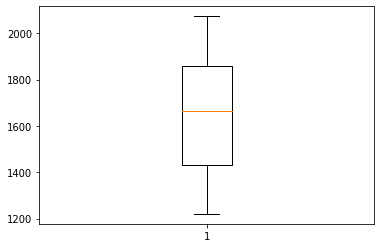

In [13]:
# data split
n_test = 12
# define config
config = [3, 12, 64, 3, 100, 200, 100]                                          #<---- CNN-LSTM
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('cnn-lstm', scores)